Proposal for classification of radio signals into pulsars or non-pulsar using K-nearest neighbors

INTRODUCTION:

A pulsar is a highly magnetized rotating neutron star that emits beams of electromagnetic radiation out of its magnetic poles.

Since pulsars rotate rapidly, the emission of a pulsar forms a pattern that repeats periodically. This emission pattern varies slightly with each rotation and is unique for a pulsar. Therefore, the signal from a pulsar is averaged over many rotations giving us the fold/integrated profile of a pulsar.

In practice, most signals are due to radio frequency interference (RFI) and noise. Without additional information, all “candidate” signals collected by a radio telescope could be classified as pulsars. To help differentiate pulsars and non-pulsar signals, we also use the DM-SNR (Dispersion Measure vs Signal to Noise Ratio) curve for the signal.

Our question is: Given a new candidate signal, can we classify it as a pulsar or non-pulsar?

We use the HTRU2 data set available at the UCL machine learning repository. In this dataset, we use characteristics such as mean, standard deviation, excess kurtosis, and skewness for both the integrated profile and DM-SNR curve of a signal. For each candidate signal, there is a class label which classifies the detection as either a pulsar(1) or non-pulsar(0); a human annotator has classified the signals.


In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
options(repr.plot.height = 9, repr.plot.width = 9)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# Column names are:
# M_IP -> Mean of the Integrated Profile
# SD_IP -> Standard deviation of the Integrated Profile
# EK_IP -> Excess kurtosis of the Integrated Profile
# SK_IP -> Skewness of the Integrated Profile
# M_DM_SNR -> Mean of the DM-SNR curve
# SD_DM_SNR -> Standard deviation of the DM-SNR curve
# EK_DM_SNR -> Excess kurtosis of the DM-SNR curve
# SK_DM_SNR -> Skewness of the DM-SNR curve
# CLASS -> Label for an observation pulsar(1) and non-pulsar(0)
pulsar <- read_csv("HTRU_2.csv", 
                   col_names = c("M_IP","SD_IP","EK_IP","SK_IP","M_DM_SNR","SD_DM_SNR","EK_DM_SNR","SK_DM_SNR","CLASS")) |>
                mutate(CLASS = as_factor(CLASS))
pulsar
# CLASS variable is converted from double to factor type with two levels
# The data is tidy

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): M_IP, SD_IP, EK_IP, SK_IP, M_DM_SNR, SD_DM_SNR, EK_DM_SNR, SK_DM_SN...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


In [4]:
pulsar_split <- initial_split(pulsar, prop = 0.8, strata = CLASS)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

In [17]:
pulsar_recipe <- recipe(CLASS ~ EK_IP + M_IP + M_DM_SNR,data = pulsar_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = CLASS)

k_grid_vals <- tibble(neighbors = seq(1:10))

pulsar_fit <- workflow() |>
                add_recipe(pulsar_recipe) |>
                add_model(knn_spec) |>
                tune_grid(resamples = pulsar_vfold, grid = k_grid_vals) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

In [18]:
pulsar_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9668247,5,0.001785754,Preprocessor1_Model01
2,accuracy,binary,0.9668247,5,0.001785754,Preprocessor1_Model02
3,accuracy,binary,0.9767423,5,0.001253325,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.9779994,5,0.001195827,Preprocessor1_Model08
9,accuracy,binary,0.9777200,5,0.001800026,Preprocessor1_Model09
10,accuracy,binary,0.9777200,5,0.001800026,Preprocessor1_Model10


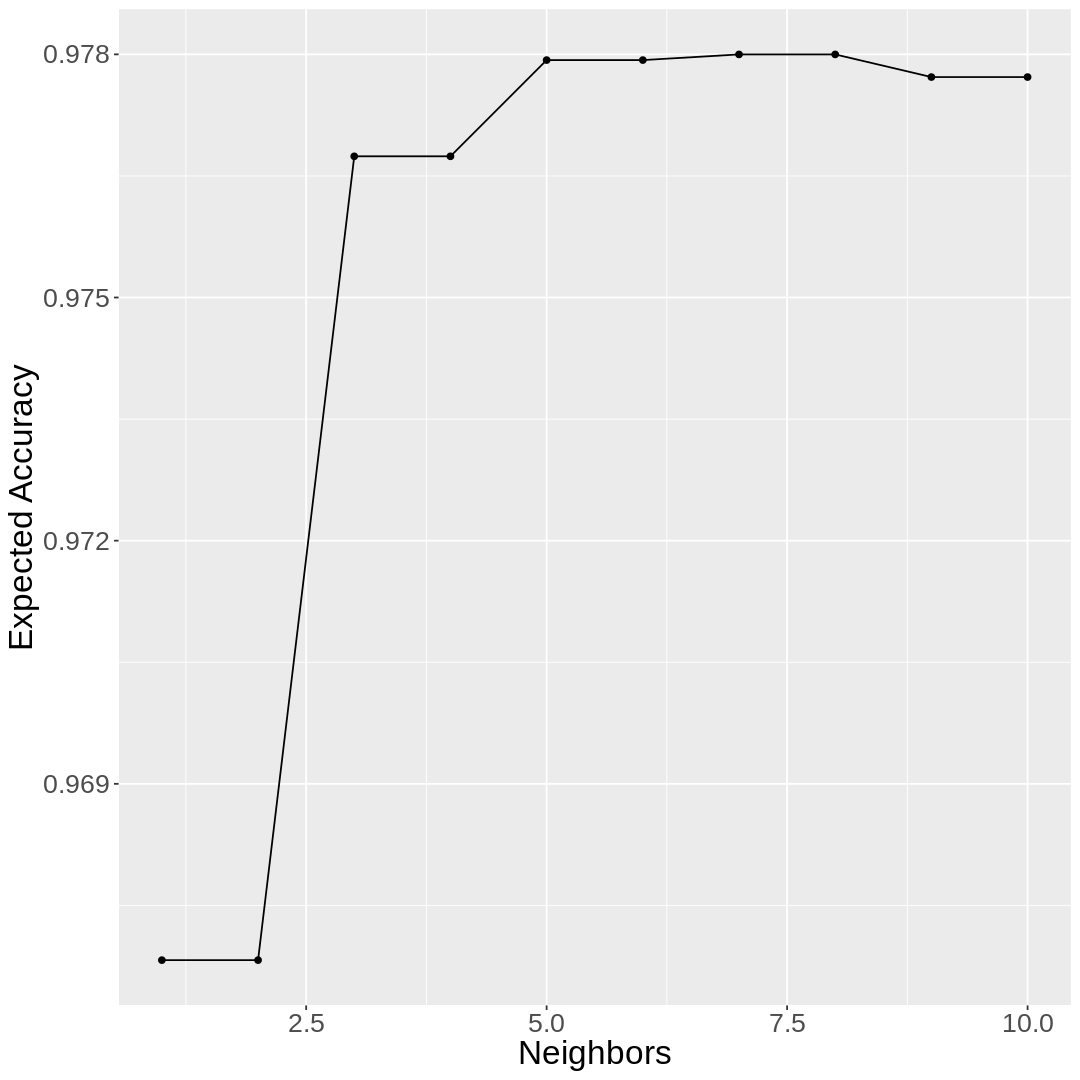

In [19]:
K_graph <- ggplot(pulsar_fit, aes(x = neighbors, y = mean)) +
            geom_point() +
            geom_line() +
            labs(x = "Neighbors", y = "Expected Accuracy") +
            theme(text = element_text(size = 20))
K_graph

In [24]:
knn_spec_6 <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
                set_engine("kknn") |>
                set_mode("classification")

pulsar_fit <- workflow() |>
                add_recipe(pulsar_recipe) |>
                add_model(knn_spec_6) |>
                fit(pulsar_train) 

In [30]:
pulsar_predict <- predict(pulsar_fit, pulsar_test) |>
                    bind_cols(pulsar_test)

pulsar_predict

pulsar_accuracy <- pulsar_predict |>
                    metrics(truth = CLASS, estimate = .pred_class)

pulsar_conf_mat <- pulsar_predict |>
                    conf_mat(truth = CLASS, estimate = .pred_class)

pulsar_conf_mat

.pred_class,M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,88.72656,40.67223,0.60086608,1.1234917,1.1789298,11.468720,14.269573,252.56731,0
0,119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
0,136.09375,51.69100,-0.04590893,-0.2718164,9.3428094,38.096400,4.345438,18.67365,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,127.0703,47.66356,0.006552426,-0.12363370,0.8536789,11.19721,16.12270,296.5077,0
0,136.4297,59.84742,-0.187845581,-0.73812297,1.2968227,12.16606,15.45026,285.9310,0
0,114.5078,53.90240,0.201161383,-0.02478884,1.9464883,13.38173,10.00797,134.2389,0


          Truth
Prediction    0    1
         0 3253   41
         1   20  266

In [ ]:
# create the grid of area/smoothness vals, and arrange in a data frame
ekip_grid <- seq(min(pulsar_train$EK_IP), 
                max(pulsar_train$EK_IP), 
                length.out = 100)
mip_grid <- seq(min(pulsar_train$M_IP), 
                max(pulsar_train$M_IP), 
                length.out = 100)
mdmsnr_grid <- seq(min(pulsar_train$M_DM_SNR), 
                max(pulsar_train$M_DM_SNR), 
                length.out = 100)
threegrid <- as_tibble(expand.grid(EK_IP = ekip_grid, 
                                M_IP = mip_grid,
                                  M_DM_SNR = mdmsnr_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(pulsar_fit, threegrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, threegrid) |> 
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = pulsar_train, 
             mapping = aes(x = EK_IP, 
                           y = M_IP, 
                           color = CLASS), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = EK_IP, 
                           y = M_IP, 
                           color = CLASS), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Pulsar or Non-Pulsar", 
       x = "Area (standardized)", 
       y = "Smoothness (standardized)") +
  scale_color_manual(labels = c("Malignant", "Benign"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

wkflw_plot